In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install split-folders

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import splitfolders

In [4]:
path = "/content/drive/MyDrive/bacteria_dimensions_project/separated_cells_constsize/"#dataset of tagged images
print(os.listdir(path))
splitfolders.ratio(path,seed=1337, output="isolate_splitted_constSize", ratio=(0.7, 0.2, 0.1))

['good_img', 'notgood_img']


Copying files: 1212 files [00:22, 54.64 files/s] 


Training the model

In [5]:
def get_train_image_quant(directory):
    datagen = ImageDataGenerator()
    data = datagen.flow_from_directory(directory)
    unique = np.unique(data.classes, return_counts=True)
    labels_dict = dict(zip(unique[0], unique[1]))
    print(labels_dict)
    image_quant_per_class = []
    for key in labels_dict:
        for i in range(labels_dict[key]):
            image_quant_per_class.append(key)
    return image_quant_per_class

def get_class_weights(labels, one_hot=False):
        if one_hot is False:
            n_classes = max(labels) + 1
        else:
            n_classes = len(labels[0])
        class_counts = [0 for _ in range(int(n_classes))]
        if one_hot is False:
            for label in labels:
                class_counts[label] += 1
        else:
            for label in labels:
                class_counts[label.index(1)] += 1
        return {i : (1. / class_counts[i]) * float(len(labels)) / float(n_classes) for i in range(int(n_classes))}


def first_train(train_dir,val_dir,path_to_model):
    img_width, img_height = 128, 128

    train_data_dir = train_dir
    validation_data_dir = val_dir

    train_images_labels = get_train_image_quant(train_data_dir) # for weights balancing
    print (get_class_weights(train_images_labels))


    nb_train_samples = 177
    nb_validation_samples = 50

    epochs = 50
    batch_size = 16


    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    train_datagen = ImageDataGenerator(
         horizontal_flip=True,
         vertical_flip=True,
         rescale=1. / 255
    )


    test_datagen = ImageDataGenerator(rescale=1. / 255)#rescale=1. / 255

    train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')



    # top layer
    base_model = tensorflow.keras.applications.efficientnet_v2.EfficientNetV2M(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=input_shape,
            include_preprocessing=False,
            include_top=False)  # Do not include the ImageNet classifier at the top.
    base_model.trainable = False

    # top layer
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)

    METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
      tensorflow.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
     ]
    num_train_steps = 177 * 10
    from tensorflow.keras.optimizers.schedules import PolynomialDecay
    lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)

    opt = Adam(learning_rate=lr_scheduler)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    print(model.summary())


    early = EarlyStopping(monitor='val_loss', min_delta=0.01, \
        patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(path_to_model, monitor='val_loss',verbose=1,   # val_recall_metric
                                    save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=300,#epochs,
    verbose=1,
    callbacks=[ early,checkpoint],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size,
    class_weight=get_class_weights(train_images_labels)
    )

In [ ]:
#train
train = r"isolate_splitted_constSize/train"
val =   r"isolate_splitted_constSize/val"
print(train)
print(val)
first_train(train,val, path_to_model=r"/content/drive/MyDrive/bacteria_dimensions_project/CV7_effnet_.h5")

isolate_splitted_constSize/train
isolate_splitted_constSize/val
Found 847 images belonging to 2 classes.
{0: 424, 1: 423}
{0: 0.9988207547169811, 1: 1.0011820330969268}
Found 847 images belonging to 2 classes.
Found 242 images belonging to 2 classes.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-m (Function  (None, 4, 4, 1280)        53150388  
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 16)                20496     
      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 30s 964ms/step - loss: 0.6592 - accuracy: 0.6591 - val_loss: 0.6225 - val_accuracy: 0.6875
Epoch 2/300
11/11 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.7045
Epoch 2: val_loss improved from 0.62252 to 0.59088, saving model to /content/drive/MyDrive/bacteria_dimensions_project/CV7_effnet_.h5
11/11 [==============================] - 3s 283ms/step - loss: 0.5996 - accuracy: 0.7045 - val_loss: 0.5909 - val_accuracy: 0.7500
Epoch 3/300
11/11 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.7614
Epoch 3: val_loss improved from 0.59088 to 0.55431, saving model to /content/drive/MyDrive/bacteria_dimensions_project/CV7_effnet_.h5
11/11 [==============================] - 3s 281ms/step - loss: 0.5841 - accuracy: 0.7614 - val_loss: 0.5543 - val_accuracy: 0.7292
Epoch 4/300
11/11 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.7670
Epoch 4: val_loss improved from 0.55431 to 0.52232, s

Evaluation:

In [6]:
model = tf.keras.models.load_model("/content/drive/MyDrive/bacteria_dimensions_project/CV7_effnet_.h5")

In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)#rescale=1. / 255

test_generator = test_datagen.flow_from_directory(
r"isolate_splitted_constSize/test",
target_size=(128, 128),
batch_size=16,
class_mode='categorical')
evaluation = model.evaluate(test_generator, steps=25//16)
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

Found 123 images belonging to 2 classes.
1/1 [==============================] - 10s 10s/step - loss: 0.2586 - accuracy: 0.8750
Loss: 0.25858378410339355
Accuracy: 0.875


Predictions:

In [8]:
predicted_good_control_dir = '/content/drive/MyDrive/bacteria_dimensions_project/predicted_good_control/'
predicted_good_acid_dir = '/content/drive/MyDrive/bacteria_dimensions_project/predicted_good_acidic/'

1/1 [==============================] - 0s 50ms/step
1
1/1 [==============================] - 0s 50ms/step
1
1/1 [==============================] - 0s 52ms/step
1
1/1 [==============================] - 0s 69ms/step
1
1/1 [==============================] - 0s 83ms/step
0


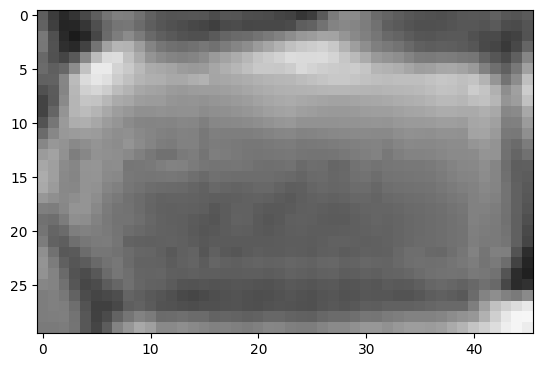

1
1/1 [==============================] - 0s 70ms/step
0


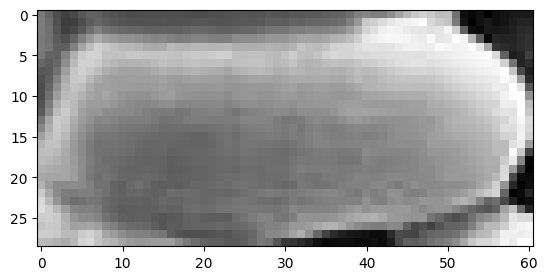

2
1/1 [==============================] - 0s 66ms/step
0


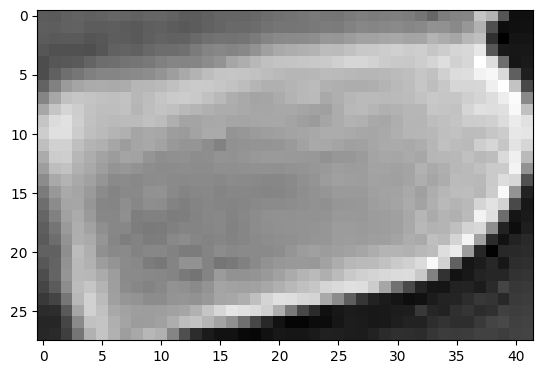

3
1/1 [==============================] - 0s 71ms/step
1
1/1 [==============================] - 0s 75ms/step
1
1/1 [==============================] - 0s 65ms/step
1
1/1 [==============================] - 0s 71ms/step
1
1/1 [==============================] - 0s 67ms/step
1
1/1 [==============================] - 0s 73ms/step
1
1/1 [==============================] - 0s 67ms/step
1
1/1 [==============================] - 0s 71ms/step
1
1/1 [==============================] - 0s 68ms/step
0


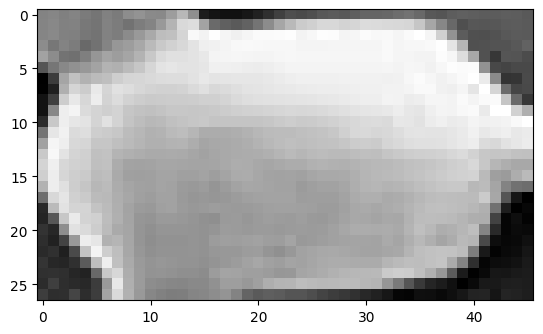

4
1/1 [==============================] - 0s 81ms/step
1
1/1 [==============================] - 0s 73ms/step
1
1/1 [==============================] - 0s 91ms/step
1
1/1 [==============================] - 0s 84ms/step
1
1/1 [==============================] - 0s 80ms/step
0


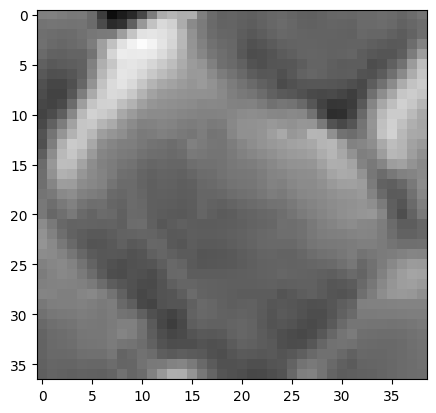

5
1/1 [==============================] - 0s 51ms/step
1
1/1 [==============================] - 0s 51ms/step
1
1/1 [==============================] - 0s 52ms/step
1
1/1 [==============================] - 0s 45ms/step
1
1/1 [==============================] - 0s 45ms/step
0


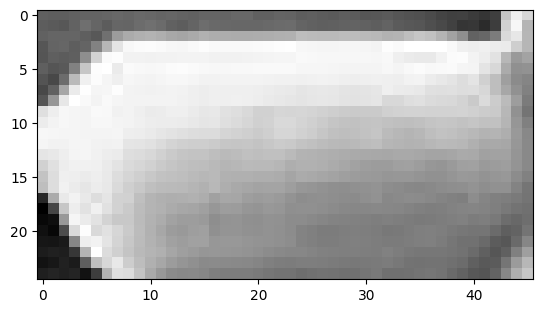

6
1/1 [==============================] - 0s 48ms/step
1
1/1 [==============================] - 0s 53ms/step
0


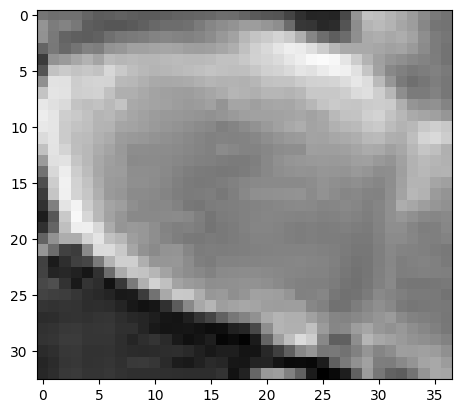

7
1/1 [==============================] - 0s 46ms/step
1
1/1 [==============================] - 0s 48ms/step
1
1/1 [==============================] - 0s 44ms/step
1
1/1 [==============================] - 0s 45ms/step
1
1/1 [==============================] - 0s 51ms/step
1
1/1 [==============================] - 0s 47ms/step
0


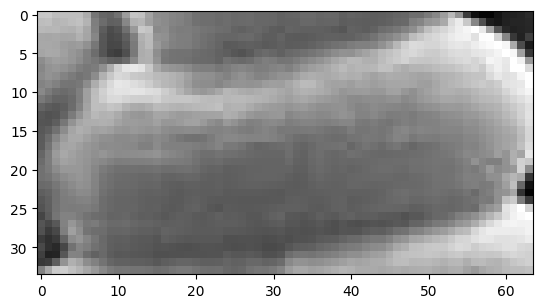

8
1/1 [==============================] - 0s 44ms/step
0


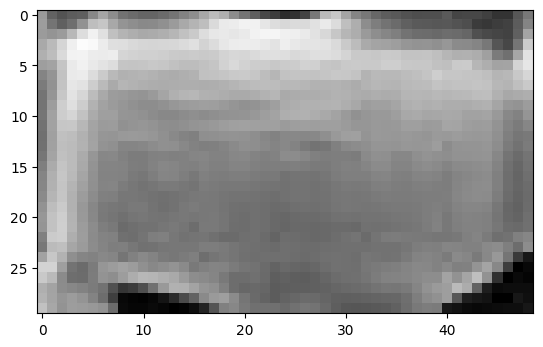

9
1/1 [==============================] - 0s 45ms/step
1
1/1 [==============================] - 0s 52ms/step
0


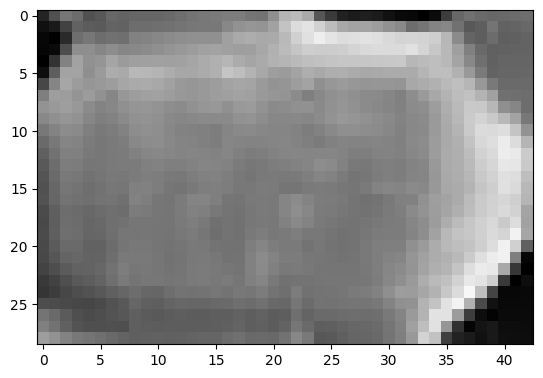

10
1/1 [==============================] - 0s 52ms/step
0


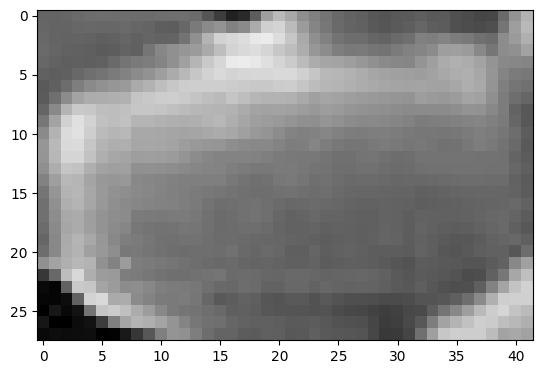

11
1/1 [==============================] - 0s 52ms/step
0


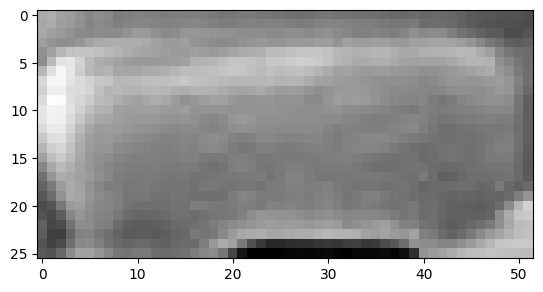

12
1/1 [==============================] - 0s 46ms/step
0


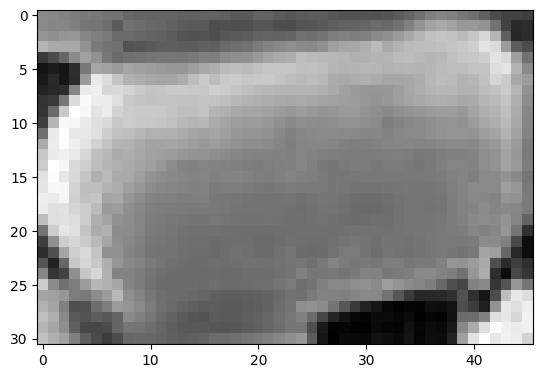

13
1/1 [==============================] - 0s 50ms/step
0


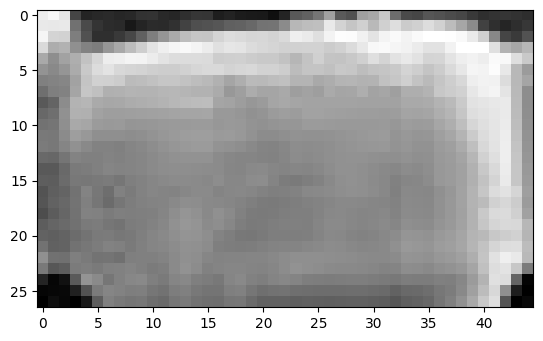

14
1/1 [==============================] - 0s 47ms/step
1
1/1 [==============================] - 0s 48ms/step
1
1/1 [==============================] - 0s 48ms/step
0


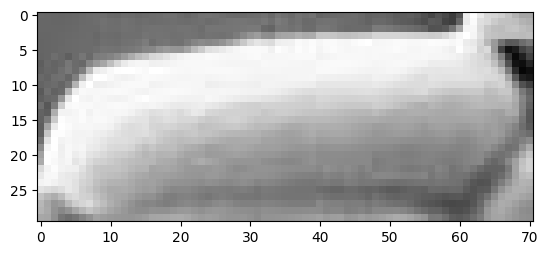

15
1/1 [==============================] - 0s 48ms/step
1
1/1 [==============================] - 0s 51ms/step
1
1/1 [==============================] - 0s 50ms/step
1
1/1 [==============================] - 0s 46ms/step
1
1/1 [==============================] - 0s 46ms/step
1
1/1 [==============================] - 0s 45ms/step
1
1/1 [==============================] - 0s 46ms/step
0


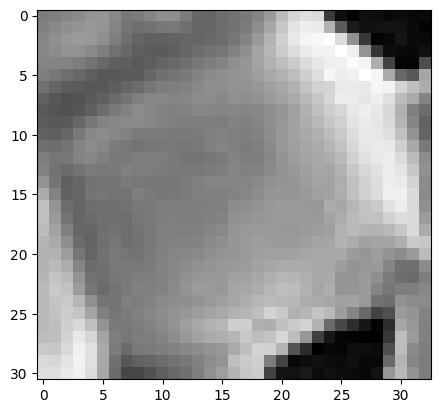

16
1/1 [==============================] - 0s 44ms/step
0


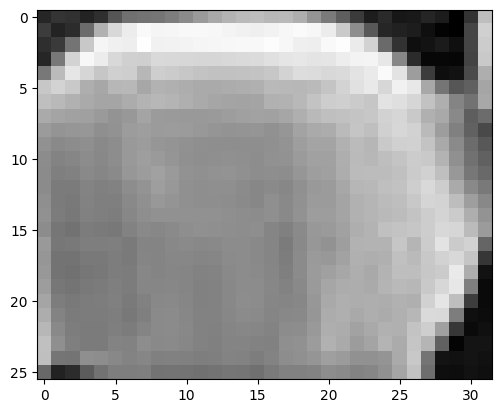

17
1/1 [==============================] - 0s 46ms/step
1
1/1 [==============================] - 0s 48ms/step
0


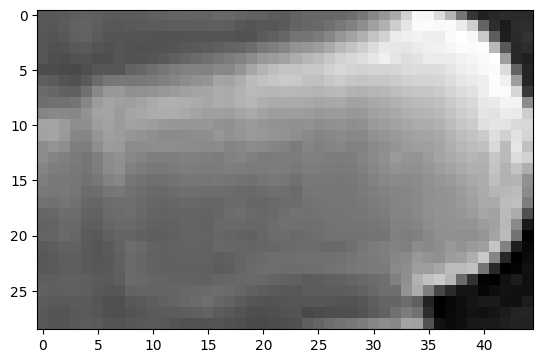

18
1/1 [==============================] - 0s 45ms/step
0


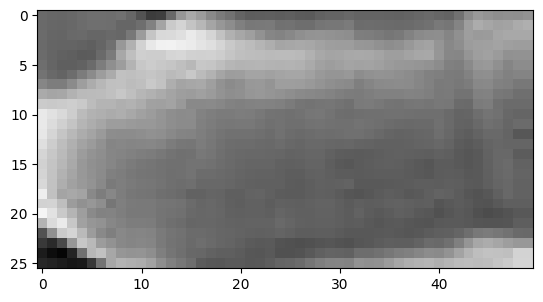

19
1/1 [==============================] - 0s 49ms/step
0


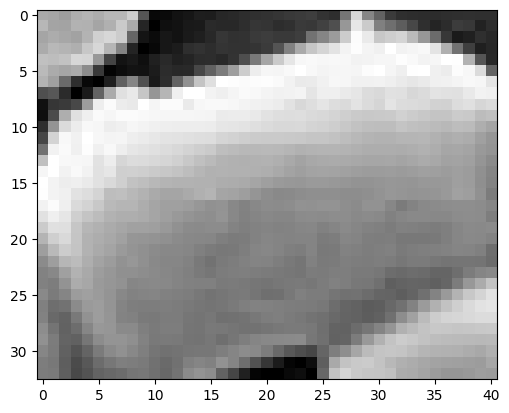

20


In [31]:
#Predict good control images
path = r"/content/drive/MyDrive/bacteria_dimensions_project/control_seperate_cells/"#control bacteria images
files = os.listdir(path)
(img_width, img_height) = (128,128)

count=0
for filename in files:
  img = image.load_img(path+filename)
  if img.size[1] > img.size[0]:
    img = img.rotate(90, expand=True)
  img = img.resize((img_width, img_height))
  x = image.img_to_array(img)
  x = x / 255.0
  x = np.expand_dims(x, axis=0)

  predictions = model.predict(x, batch_size=10)
  predicted_class_index = tf.argmax(predictions[0]).numpy()
  print (predicted_class_index)
  if predicted_class_index==0:
    count+=1
    img = image.load_img(path+filename)
    if img.size[1] > img.size[0]:
      img = img.rotate(90, expand=True)
    plt.imshow(img)
    plt.show()
    print(count)
    image.save_img(predicted_good_control_dir+filename, img)
    if count==20:#number of images required
      break


1/1 [==============================] - 0s 69ms/step
1
1/1 [==============================] - 0s 69ms/step
1
1/1 [==============================] - 0s 79ms/step
1
1/1 [==============================] - 0s 66ms/step
1
1/1 [==============================] - 0s 69ms/step
1
1/1 [==============================] - 0s 64ms/step
1
1/1 [==============================] - 0s 73ms/step
1
1/1 [==============================] - 0s 83ms/step
1
1/1 [==============================] - 0s 72ms/step
1
1/1 [==============================] - 0s 145ms/step
1
1/1 [==============================] - 0s 147ms/step
1
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 157ms/step
1
1/1 [==============================] - 0s 146ms/step
1
1/1 [==============================] - 0s 158ms/step
1
1/1 [==============================] - 0s 143ms/step
1
1/1 [==============================] - 0s 135ms/step
1
1/1 [==============================] - 0s 130ms/step
1
1/1 [==============

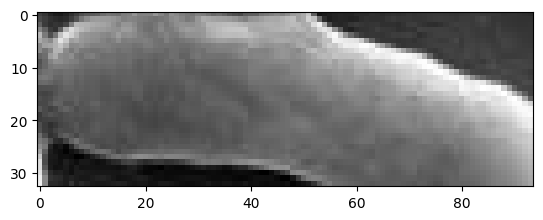

1
1/1 [==============================] - 0s 169ms/step
1
1/1 [==============================] - 0s 144ms/step
1
1/1 [==============================] - 0s 156ms/step
1
1/1 [==============================] - 0s 71ms/step
1
1/1 [==============================] - 0s 70ms/step
0


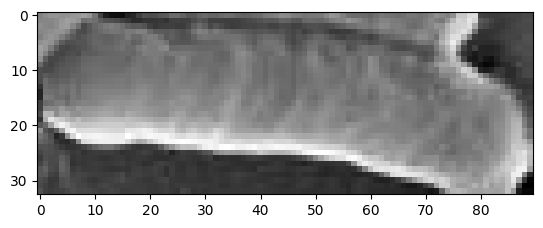

2
1/1 [==============================] - 0s 66ms/step
1
1/1 [==============================] - 0s 65ms/step
1
1/1 [==============================] - 0s 126ms/step
1
1/1 [==============================] - 0s 121ms/step
0


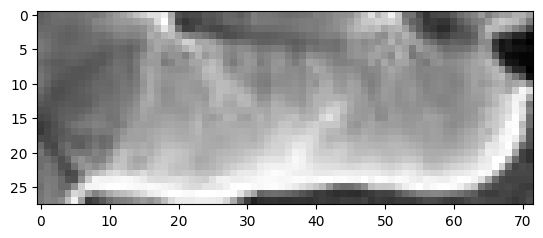

3
1/1 [==============================] - 0s 238ms/step
1
1/1 [==============================] - 0s 103ms/step
1
1/1 [==============================] - 0s 89ms/step
1
1/1 [==============================] - 0s 64ms/step
1
1/1 [==============================] - 0s 238ms/step
0


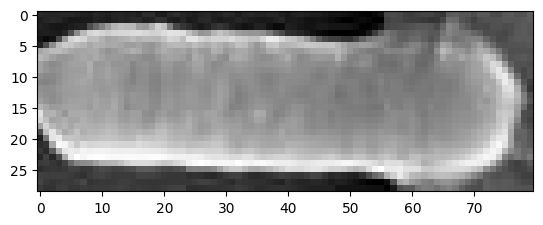

4
1/1 [==============================] - 0s 63ms/step
1
1/1 [==============================] - 0s 65ms/step
1
1/1 [==============================] - 0s 65ms/step
1
1/1 [==============================] - 0s 66ms/step
1
1/1 [==============================] - 0s 72ms/step
1
1/1 [==============================] - 0s 72ms/step
1
1/1 [==============================] - 0s 67ms/step
0


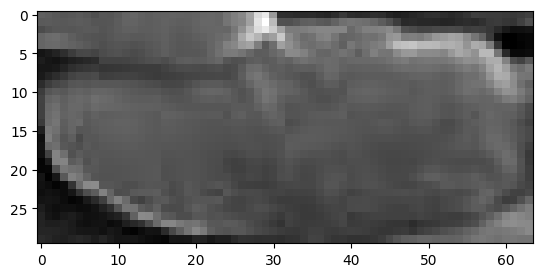

5
1/1 [==============================] - 0s 60ms/step
1
1/1 [==============================] - 0s 68ms/step
1
1/1 [==============================] - 0s 66ms/step
0


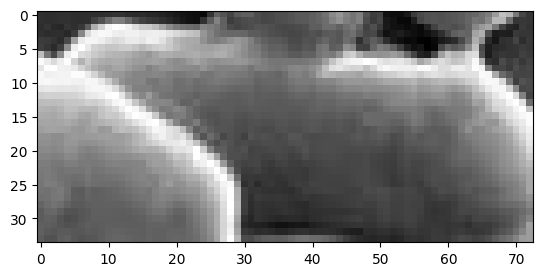

6
1/1 [==============================] - 0s 63ms/step
1
1/1 [==============================] - 0s 62ms/step
1
1/1 [==============================] - 0s 74ms/step
1
1/1 [==============================] - 0s 64ms/step
1
1/1 [==============================] - 0s 70ms/step
1
1/1 [==============================] - 0s 71ms/step
1
1/1 [==============================] - 0s 68ms/step
0


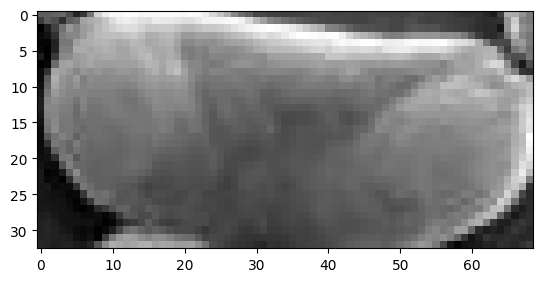

7
1/1 [==============================] - 0s 68ms/step
1
1/1 [==============================] - 0s 67ms/step
1
1/1 [==============================] - 0s 66ms/step
1
1/1 [==============================] - 0s 63ms/step
1
1/1 [==============================] - 0s 64ms/step
1
1/1 [==============================] - 0s 75ms/step
1
1/1 [==============================] - 0s 70ms/step
1
1/1 [==============================] - 0s 72ms/step
1
1/1 [==============================] - 0s 95ms/step
0


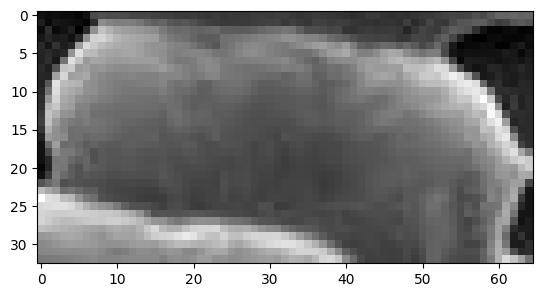

8
1/1 [==============================] - 0s 150ms/step
0


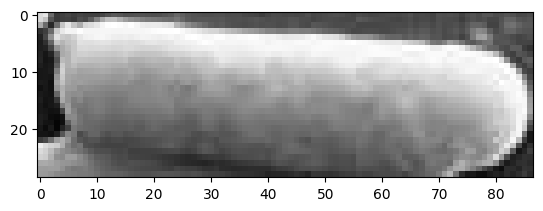

9
1/1 [==============================] - 0s 138ms/step
0


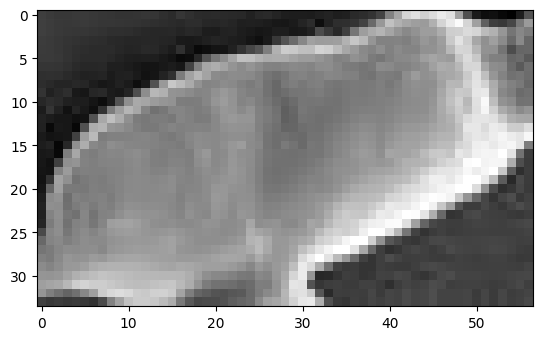

10
1/1 [==============================] - 0s 103ms/step
0


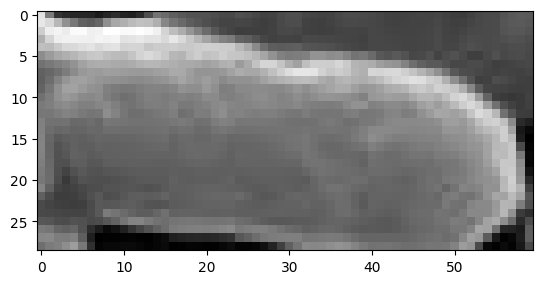

11
1/1 [==============================] - 0s 158ms/step
0


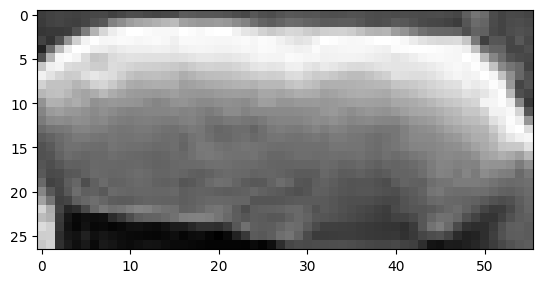

12
1/1 [==============================] - 0s 141ms/step
1
1/1 [==============================] - 0s 164ms/step
1
1/1 [==============================] - 0s 140ms/step
1
1/1 [==============================] - 0s 70ms/step
0


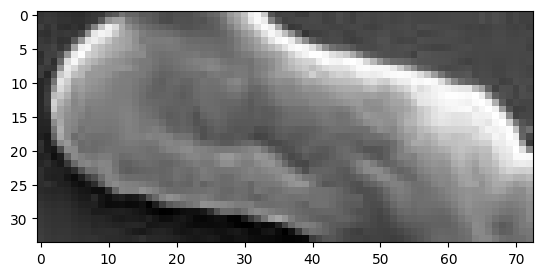

13
1/1 [==============================] - 0s 72ms/step
1
1/1 [==============================] - 0s 70ms/step
0


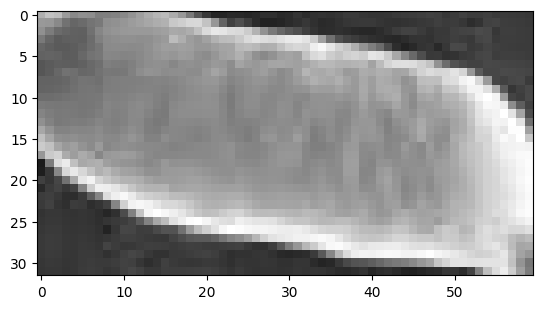

14
1/1 [==============================] - 0s 66ms/step
1
1/1 [==============================] - 0s 71ms/step
0


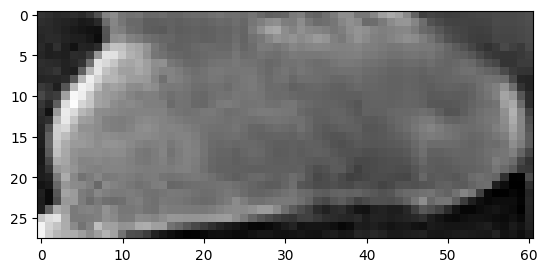

15
1/1 [==============================] - 0s 68ms/step
1
1/1 [==============================] - 0s 64ms/step
1
1/1 [==============================] - 0s 67ms/step
1
1/1 [==============================] - 0s 90ms/step
1
1/1 [==============================] - 0s 72ms/step
1
1/1 [==============================] - 0s 73ms/step
1
1/1 [==============================] - 0s 65ms/step
1
1/1 [==============================] - 0s 72ms/step
1
1/1 [==============================] - 0s 87ms/step
1
1/1 [==============================] - 0s 78ms/step
1
1/1 [==============================] - 0s 69ms/step
1
1/1 [==============================] - 0s 71ms/step
1
1/1 [==============================] - 0s 72ms/step
0


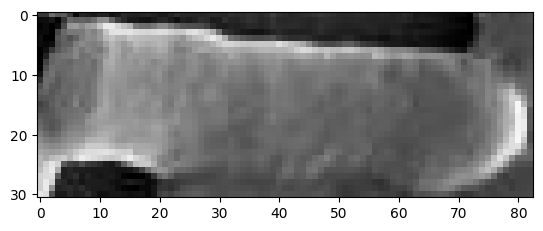

16
1/1 [==============================] - 0s 66ms/step
1
1/1 [==============================] - 0s 70ms/step
0


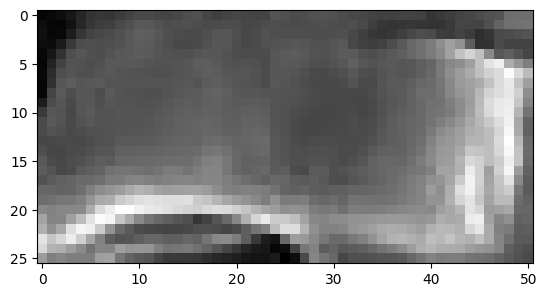

17
1/1 [==============================] - 0s 76ms/step
1
1/1 [==============================] - 0s 80ms/step
1
1/1 [==============================] - 0s 70ms/step
1
1/1 [==============================] - 0s 80ms/step
1
1/1 [==============================] - 0s 73ms/step
1
1/1 [==============================] - 0s 68ms/step
1
1/1 [==============================] - 0s 103ms/step
1
1/1 [==============================] - 0s 74ms/step
1
1/1 [==============================] - 0s 72ms/step
1
1/1 [==============================] - 0s 65ms/step
1
1/1 [==============================] - 0s 66ms/step
1
1/1 [==============================] - 0s 64ms/step
1
1/1 [==============================] - 0s 68ms/step
1
1/1 [==============================] - 0s 95ms/step
1
1/1 [==============================] - 0s 66ms/step
0


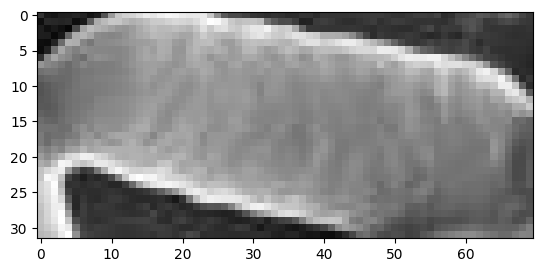

18
1/1 [==============================] - 0s 79ms/step
1
1/1 [==============================] - 0s 144ms/step
1
1/1 [==============================] - 0s 68ms/step
0


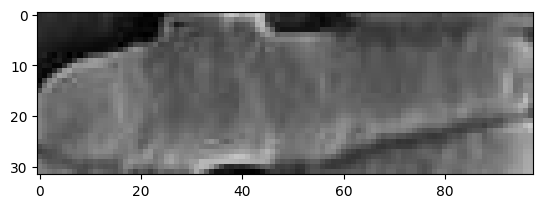

19
1/1 [==============================] - 0s 45ms/step
0


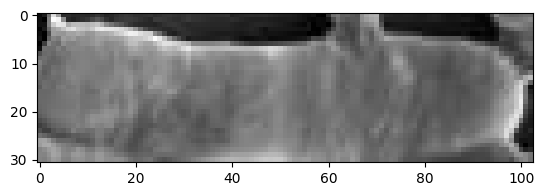

20


In [32]:
#Predict good acidic images
path = r"/content/drive/MyDrive/bacteria_dimensions_project/acid_seperate_cells/"#acidic bacteria images
files = os.listdir(path)
(img_width, img_height) = (128,128)

count=0
for filename in files:
  img = image.load_img(path+filename)
  if img.size[1] > img.size[0]:
    img = img.rotate(90, expand=True)
  img = img.resize((img_width, img_height))
  x = image.img_to_array(img)
  x = x / 255.0
  x = np.expand_dims(x, axis=0)

  predictions = model.predict(x, batch_size=10)
  predicted_class_index = tf.argmax(predictions[0]).numpy()
  print (predicted_class_index)
  if predicted_class_index==0:
    count+=1
    img = image.load_img(path+filename)
    if img.size[1] > img.size[0]:
      img = img.rotate(90, expand=True)
    plt.imshow(img)
    plt.show()
    print(count)
    image.save_img(predicted_good_acid_dir+filename, img)
    if count==20:#number of images required
      break

In [33]:
print(len(os.listdir(predicted_good_control_dir)))
print(len(os.listdir(predicted_good_acid_dir)))

20
20
